<a href="https://colab.research.google.com/github/CharFox1/CompVisProj/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import numpy as np

In [3]:
!unzip handwrittenChars.zip

Archive:  handwrittenChars.zip
   creating: handwrittenChars/
   creating: handwrittenChars/.ipynb_checkpoints/
  inflating: handwrittenChars/.ipynb_checkpoints/parseHandwrittenChars-checkpoint.ipynb  
  inflating: handwrittenChars/parseHandwrittenChars.ipynb  
  inflating: handwrittenChars/trainSmall.npy  
  inflating: handwrittenChars/valSmall.npy  


In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [237]:
# resnet block to be used in models below
# code modified from "resnet-34-pytorch-starter-kit"

class resBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, bias=False):
    super(resBlock, self).__init__()
    
    self.cnn1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )

    self.cnn2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

    # if the output image will be a different size than the input
    # must reshape residual to fit new output shape
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )
    # otherwise just pass it through 
    else:
      self.shortcut = nn.Sequential()

  def forward(self, x):
    residual = x
    x = self.cnn1(x)
    x = self.cnn2(x)
    x += self.shortcut(residual)
    x = nn.ReLU(True)(x)
    return x


In [326]:
# simple conv network to test finding single characters
# uses resnet structure

class convDemoNet(nn.Module):
  def __init__(self, numClasses):
    super(convDemoNet, self).__init__()
    
    self.block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.block2 = nn.Sequential(
        nn.MaxPool2d(1, 1),
        resBlock(64, 64),
        resBlock(64, 64, 2)
    )

    self.block3 = nn.Sequential(
        resBlock(64, 128),
        resBlock(128, 128, 2)
    )

    self.block4 = nn.Sequential(
        resBlock(128, 256),
        resBlock(256, 256, 2)
    )

    self.block5 = nn.Sequential(
        resBlock(256, 512),
        resBlock(512, 512, 2)
    )

    self.avgpool = nn.AvgPool2d(2)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(512, 512)
    self.l2 = nn.Linear(512, 256)
    self.l3 = nn.Linear(256, numClasses)
    #self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    return x

In [327]:
# small function to turn int index into one hot encoding
def oneHot(num, numClasses):
  output = [0] * numClasses
  output[num] = 1
  return output

training data size: 78000
validation data size: 13209
training data shape: (32, 32)


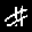

data type of image = <class 'numpy.ndarray'>
training data label: #
each index in dataset has image (32x32) and char label
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [328]:
# get conv demo data (https://www.kaggle.com/vaibhao/handwritten-characters)
from google.colab.patches import cv2_imshow #allows us to show images

# grab small files (created from larger dataset)
# this is the location they should be in the github
# if you are running in collab, you need to import the handwrittenChars folder as a zip
# you can unzip it with "!unzip handwrittenChars.zip" in a separate cell
with open("handwrittenChars/trainSmall.npy", "rb") as f:
    conv_train_data = np.load(f, allow_pickle=True)

with open("handwrittenChars/valSmall.npy", "rb") as f:
    conv_val_data = np.load(f, allow_pickle=True)

print("training data size:", len(conv_train_data))
print("validation data size:", len(conv_val_data))

print("training data shape:", conv_train_data[1201][0].shape)
cv2_imshow(conv_train_data[1201][0])
print("data type of image =", type(conv_train_data[1201][0]))
print("training data label:", conv_train_data[1201][1])
print("each index in dataset has image (32x32) and char label")
print(conv_train_data[1201][0])

In [329]:
labels = []
for i in conv_train_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the training dataset")

for i in conv_val_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the validation dataset")

labelDict = {}
for i in range(len(labels)):
  labelDict[i] = labels[i]

print(labelDict)
invertedLabelDict = {y:x for x,y in labelDict.items()}
print(invertedLabelDict)

there are 39 labels in the training dataset
there are 39 labels in the validation dataset
{0: '#', 1: '$', 2: '&', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '@', 14: 'A', 15: 'B', 16: 'C', 17: 'D', 18: 'E', 19: 'F', 20: 'G', 21: 'H', 22: 'I', 23: 'J', 24: 'K', 25: 'L', 26: 'M', 27: 'N', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z'}
{'#': 0, '$': 1, '&': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '@': 13, 'A': 14, 'B': 15, 'C': 16, 'D': 17, 'E': 18, 'F': 19, 'G': 20, 'H': 21, 'I': 22, 'J': 23, 'K': 24, 'L': 25, 'M': 26, 'N': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38}


In [330]:
# dataset class
class handwrittenCharsDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      image = self.images[index]
      label = tensor(self.classToNum[self.labels[index]])
      #label = tensor(oneHot(labelNum, 39))
      image = self.transform(image)
      sample = [image, label]
      return sample
    
    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [331]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_train_data, classToNum=invertedLabelDict)
train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

tensor([28, 25,  0,  0, 20, 36,  2, 18,  5,  4])
Feature batch shape: torch.Size([10, 1, 32, 32])
Labels batch shape: torch.Size([10])


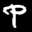

predicted P for P


In [334]:
# init model with 39 classes on output layer
# put model in gpu if available
convModel = convDemoNet(39).to(device)
#print(convModel)

testItem, testLabel = next(iter(train_dl))
print(testLabel)
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

testItem = testItem[0].unsqueeze(0).to(device)
#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = labelDict[testLabel.numpy()[0]]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

output = convModel(testItem)
y_pred = labelDict[output.argmax(1).item()]
print("predicted", y_pred, "for", testLabel)

In [396]:
import torch.optim as optim
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(convModel.parameters(), lr=0.001) 

num_epochs = 25

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    opt.zero_grad()

    outputs = convModel(images)

    loss = lossFunc(outputs, labels)
    loss.backward()
    opt.step()

    running_acc += torch.sum(outputs.argmax(1)==labels)

    running_loss += loss.item()
    if i % 1000 == 999:
      print("[%d, %5d] loss: %.5f acc: %.3f" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 1000))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 0.067 acc: 9.735001
[1,  2000] loss: 0.073 acc: 9.721001
[1,  3000] loss: 0.080 acc: 9.669001
[1,  4000] loss: 0.072 acc: 9.694000
[1,  5000] loss: 0.077 acc: 9.691000
[1,  6000] loss: 0.076 acc: 9.706000
[1,  7000] loss: 0.078 acc: 9.687000
[2,  1000] loss: 0.072 acc: 9.713000
[2,  2000] loss: 0.066 acc: 9.737000
[2,  3000] loss: 0.073 acc: 9.715000
[2,  4000] loss: 0.073 acc: 9.694000
[2,  5000] loss: 0.071 acc: 9.710000
[2,  6000] loss: 0.074 acc: 9.687000
[2,  7000] loss: 0.078 acc: 9.689000
[3,  1000] loss: 0.065 acc: 9.726001
[3,  2000] loss: 0.067 acc: 9.719001
[3,  3000] loss: 0.068 acc: 9.713000
[3,  4000] loss: 0.070 acc: 9.708000
[3,  5000] loss: 0.069 acc: 9.714001
[3,  6000] loss: 0.062 acc: 9.749001
[3,  7000] loss: 0.068 acc: 9.732000
[4,  1000] loss: 0.063 acc: 9.754001
[4,  2000] loss: 0.066 acc: 9.743000
[4,  3000] loss: 0.068 acc: 9.723001
[4,  4000] loss: 0.070 acc: 9.718000
[4,  5000] loss: 0.068 acc: 9.723001
[4,  6000] loss: 0.067 acc: 9.732000
[

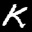

predicted K for K


In [451]:
testItem, testLabel = next(iter(train_dl))

testItem = testItem[0].unsqueeze(0).to(device)
testLabel = labelDict[testLabel[0].item()]

output = convModel(testItem)
# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)
y_pred = labelDict[output.argmax(1).item()]
print("predicted", y_pred, "for", testLabel)